### conda env activation
conda-env exp-tracking-env

### installing the requirements
!pip install -r ../mlops-zoomcamp/02-experiment-tracking/requirements.txt
#### to run in cli:
#### mlflow ui --backend-store-uri sqlite:///mlflow.dbmlflow --backend-store-uri sqlite:///02-experiment-tracking/mlflow.db

In [1]:
!python -V

Python 3.10.12


In [ ]:
git_repo_path=!git rev-parse --show-toplevel
git_repo_path=git_repo_path[0]
print(f'Repo path in the system: {git_repo_path}')

/home/nikto/study/mlops-zoomcamp


In [2]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [4]:
!pwd

/home/nikto/study/mlops-zoomcamp/02-experiment-tracking


In [5]:
import mlflow,os
experiment_name='nyc-taxi-experiment'
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/2', creation_time=1721216752638, experiment_id='2', last_update_time=1721216752638, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [6]:
# df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [7]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/home/nikto/study/mlops-zoomcamp/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829625

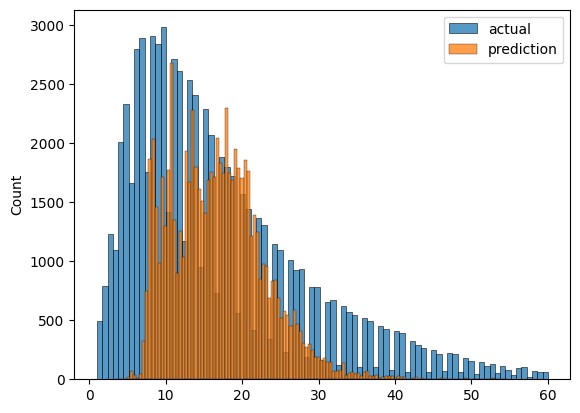

In [8]:
sns.histplot(y_train, label='actual')
sns.histplot(y_pred, label='prediction')

plt.legend()

In [9]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [10]:
# df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [11]:
len(df_train), len(df_val)

(73908, 61921)

In [12]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [13]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [14]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/nikto/study/mlops-zoomcamp/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715198889101

In [16]:
with open(f'{git_repo_path}/models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [17]:
with mlflow.start_run():
    alpha=0.01
    mlflow.set_tag('developer','proggername')
    mlflow.log_param('train-data-path','https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
    mlflow.log_param('valid-data-path','https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')
    mlflow.log_param('alpha',alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse=mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('rmse',rmse)

/home/nikto/study/mlops-zoomcamp/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
